# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.datasets as DT
import numpy.random as rd


In [2]:
import tensorflow as tf


In [3]:
tf.__version__


'2.8.0'

## Import Data

In [4]:
(X1, y1), (X2, y2) = DT.fashion_mnist.load_data()
print("Training set:", X1.shape, X1.dtype)
print("Test set:    ", X2.shape, X2.dtype)


Training set: (60000, 28, 28) uint8
Test set:     (10000, 28, 28) uint8


### View some images

(-0.5, 619.5, 309.5, -0.5)

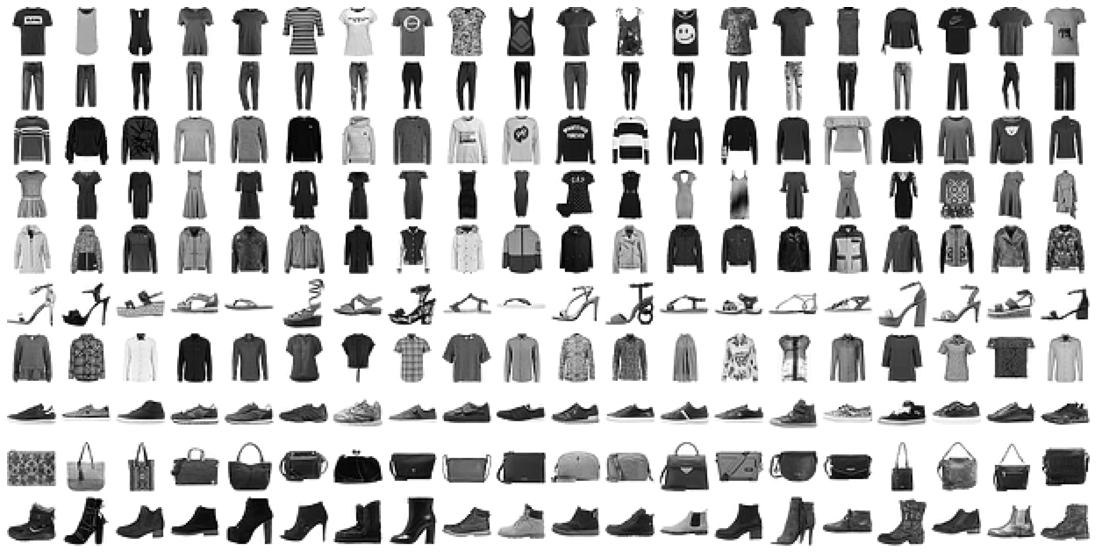

In [5]:
idxList = []
for i in range(10):
    idxTemp = np.argwhere(y1 == i).squeeze()
    idxList.append(idxTemp)


for i in range(10):
    idx = idxList[i]
    for n in range(20):
        if n == 0:
            Img = np.hstack((255 - X1[idx[n]], np.ones((28, 3)) * 255))
        else:
            Img = np.hstack((Img, 255 - X1[idx[n]], np.ones((28, 3)) * 255))

    if i == 0:
        ImgT = np.vstack((Img, np.ones((3, Img.shape[1])) * 255))
    else:
        ImgT = np.vstack((ImgT, Img, np.ones((3, Img.shape[1])) * 255))

plt.figure(figsize=(20, 10))
plt.imshow(ImgT, cmap="gray")
plt.axis("off")


## Shuffle training set and sort test set

In [6]:
idx = rd.permutation(X1.shape[0])
X1 = X1[idx]
y1 = y1[idx]


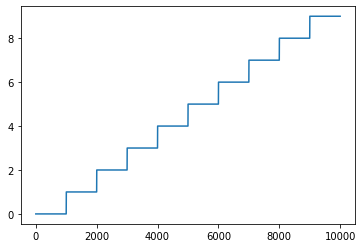

In [7]:
idx = np.argsort(y2)
y2 = y2[idx]
X2 = X2[idx]
plt.plot(y2)


## Images must be in vector format (make sure that data is in "float" format)

In [8]:
X1 = X1.reshape((60000, 28**2)) * 1.0
X2 = X2.reshape((X2.shape[0], 28**2)) * 1.0
print("Training set:", X1.shape, X1.dtype)
print("Test set:    ", X2.shape, X2.dtype)


Training set: (60000, 784) float64
Test set:     (10000, 784) float64


## Train, predict and check confusion matrix - use SGDClassifier (try others)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier().fit(X1, y1)
y2e = sgd.predict(X2)


In [10]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y2, y2e))
print("Total number of erros %d (in %d)" % (np.sum(y2 != y2e), X2.shape[0]))


[[264  16 495  31   2   1 161   0  29   1]
 [  0 956  18  20   0   0   0   1   4   1]
 [  0   8 959   2  11   0  10   0  10   0]
 [  2  33 213 695   6   0  36   1  13   1]
 [  0   6 683  14 249   2  33   0  13   0]
 [  0   1   2   0   0 926   0  33   9  29]
 [ 14   8 525  25  28   0 366   0  34   0]
 [  0   0   2   0   0  87   0 840   2  69]
 [  0   2  35   6   1  11   5   4 935   1]
 [  0   0   5   0   0  33   0  15   0 947]]
Total number of erros 2863 (in 10000)


## Since test set is ordered, one can also check erros visually

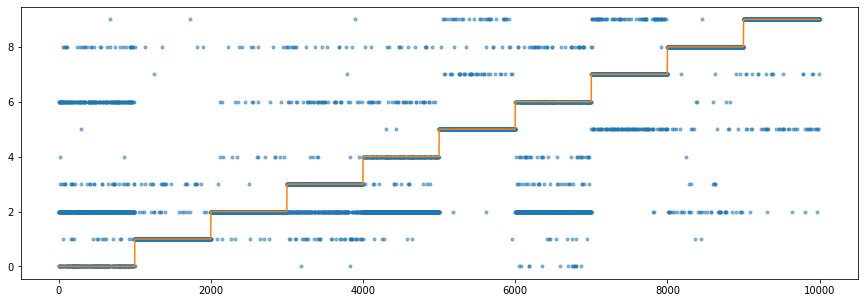

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)


## Possible problem: different means and variances of each of the 784 data dimensions

Text(0.5, 1.0, 'Standard Deviations')

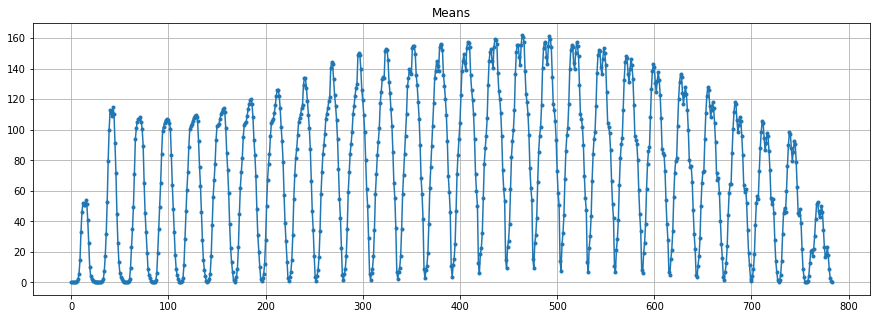

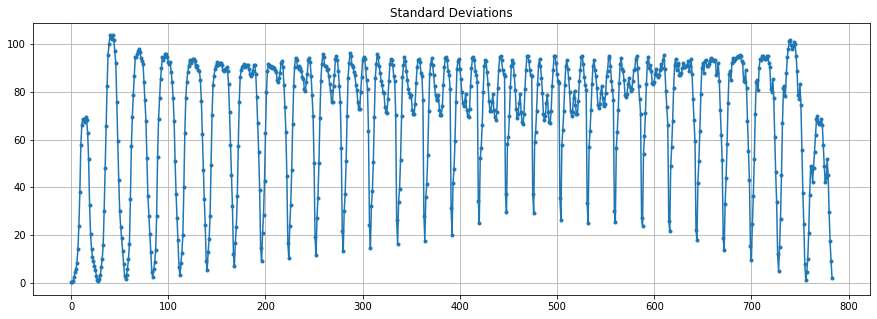

In [12]:
m = np.mean(X1, axis=0)
plt.figure(figsize=(15, 5))
plt.plot(m, ".-")
plt.grid(True)
plt.title("Means")

s = np.std(X1, axis=0)
plt.figure(figsize=(15, 5))
plt.plot(s, ".-")
plt.grid(True)
plt.title("Standard Deviations")


## Pre-process data (0 mean and unit variance in each dimension)

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler().fit(X1)
X1s = sc.transform(X1)
X2s = sc.transform(X2)


In [14]:
sgd = SGDClassifier().fit(X1s, y1)
y2e = sgd.predict(X2s)
print(confusion_matrix(y2, y2e))
print("Total number of erros %d (in %d)" % (np.sum(y2 != y2e), X2.shape[0]))


[[764   4  12  83   5   0 114   0  18   0]
 [  1 945   5  36   5   0   7   0   1   0]
 [ 10   1 718  21 122   0 116   0  12   0]
 [ 33   7  14 874  27   0  42   0   3   0]
 [  1   0 121  60 713   0 104   0   1   0]
 [  1   0   0   0   0 902   2  57  12  26]
 [132   2 112  83  92   0 539   1  39   0]
 [  0   0   0   0   0  28   0 940   2  30]
 [  5   1   2  15   2   1  35   5 934   0]
 [  0   0   1   2   0  13   0  50   1 933]]
Total number of erros 1738 (in 10000)


C:\Users\Kiko\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


## Pre-process data with PCA - use different values for total variance
## Repeat the process with the normalized data (StandarScaler) to check if it is better

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, whiten=True).fit(X1)
X1p = pca.transform(X1)
X2p = pca.transform(X2)
print("Nº of Principal Components kept: %d" % X1p.shape[1])


Nº of Principal Components kept: 84


In [16]:
sgd = SGDClassifier().fit(X1p, y1)
y2e = sgd.predict(X2p)
print(confusion_matrix(y2, y2e))
print("Total number of erros %d (in %d)" % (np.sum(y2 != y2e), X2.shape[0]))


[[792   4  14  91   8   1  64   0  26   0]
 [  5 946   6  34   4   0   2   1   2   0]
 [ 19   2 716  14 152   0  85   0  12   0]
 [ 25  11  15 885  25   0  32   0   7   0]
 [  2   1 106  48 750   0  82   0  11   0]
 [  4   0   4   1   0 911   1  47  13  19]
 [163   2 135  75 117   0 472   0  36   0]
 [  0   0   0   0   0  44   1 914   0  41]
 [  3   1   3   9   3   5  23   5 948   0]
 [  3   0   2   0   0  19   0  40   1 935]]
Total number of erros 1731 (in 10000)


# Binary classification problem (positives are class 3 - dresses)

### Change labels

In [17]:
y1b = (y1 == 3) * 1
y2b = (y2 == 3) * 1


### Train and test

In [18]:
sgd = SGDClassifier().fit(X1p, y1b)
y2e = sgd.predict(X2p)
print(confusion_matrix(y2b, y2e))
print("Total number of erros %d (in %d)" % (np.sum(y2b != y2e), y2b.shape[0]))


[[8855  145]
 [ 222  778]]
Total number of erros 367 (in 10000)


In [19]:
r1 = np.sum(y2e[y2b == 1] == 1) / (
    np.sum(y2e[y2b == 1] == 1) + np.sum(y2e[y2b == 1] == 0)
)  # recall
p1 = np.sum(y2e[y2b == 1] == 1) / (
    np.sum(y2e[y2b == 1] == 1) + np.sum(y2e[y2b == 0] == 1)
)  # precision
f1 = np.sum(y2e[y2b == 0] == 1) / (
    np.sum(y2e[y2b == 0] == 0) + np.sum(y2e[y2b == 0] == 1)
)  # fp-rate
print("Recall: %3f - Precision: %3f - FP-rate: %3f" % (r1, p1, f1))


Recall: 0.778000 - Precision: 0.842904 - FP-rate: 0.016111


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y2b, y2e))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9000
           1       0.84      0.78      0.81      1000

    accuracy                           0.96     10000
   macro avg       0.91      0.88      0.89     10000
weighted avg       0.96      0.96      0.96     10000



# Model Calibration (changing decision threshold)

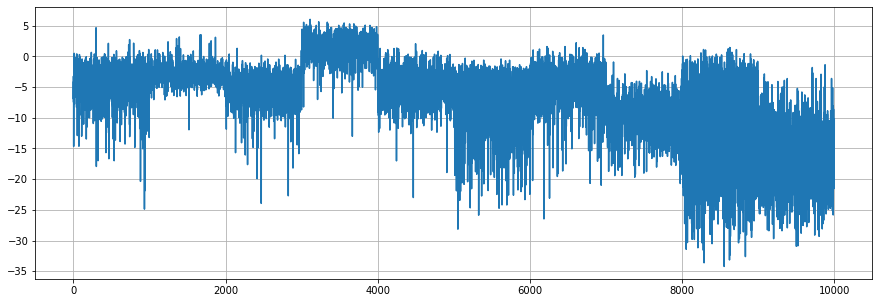

In [21]:
r2e = sgd.decision_function(X2p)
plt.figure(figsize=(15, 5))
plt.plot(r2e)
plt.grid(True)


In [22]:
print(confusion_matrix(y2b, (r2e >= 0) * 1))  # default threshold
print(
    "Total number of erros %d (in %d)" % (np.sum(y2b != (r2e >= 0) * 1), y2b.shape[0])
)


[[8855  145]
 [ 222  778]]
Total number of erros 367 (in 10000)


## Change threshold - reduce the false negatives

In [23]:
lim2 = -0.191
y2eB = (r2e > lim2) * 1
print(confusion_matrix(y2b, y2eB))
print("Total number of erros %d (in %d)" % (np.sum(y2b != y2eB), y2b.shape[0]))


[[8816  184]
 [ 194  806]]
Total number of erros 378 (in 10000)


In [24]:
r2 = np.sum(y2eB[y2b == 1] == 1) / (
    np.sum(y2eB[y2b == 1] == 1) + np.sum(y2eB[y2b == 1] == 0)
)
p2 = np.sum(y2eB[y2b == 1] == 1) / (
    np.sum(y2eB[y2b == 1] == 1) + np.sum(y2eB[y2b == 0] == 1)
)
f2 = np.sum(y2eB[y2b == 0] == 1) / (
    np.sum(y2eB[y2b == 0] == 0) + np.sum(y2eB[y2b == 0] == 1)
)
print("Recall: %3f - Precision: %3f - FP-rate: %3f" % (r2, p2, f2))


Recall: 0.806000 - Precision: 0.814141 - FP-rate: 0.020444


In [25]:
lim3 = -1.75
y2eC = (r2e > lim3) * 1
print(confusion_matrix(y2b, y2eC))
print("Total number of erros %d (in %d)" % (np.sum(y2b != y2eC), y2.shape[0]))
r3 = np.sum(y2eC[y2b == 1] == 1) / (
    np.sum(y2eC[y2b == 1] == 1) + np.sum(y2eC[y2b == 1] == 0)
)
p3 = np.sum(y2eC[y2b == 1] == 1) / (
    np.sum(y2eC[y2b == 1] == 1) + np.sum(y2eC[y2b == 0] == 1)
)
f3 = np.sum(y2eC[y2b == 0] == 1) / (
    np.sum(y2eC[y2b == 0] == 0) + np.sum(y2eC[y2b == 0] == 1)
)
print("Recall: %3f - Precision: %3f - FP-rate: %3f" % (r3, p3, f3))


[[8158  842]
 [  57  943]]
Total number of erros 899 (in 10000)
Recall: 0.943000 - Precision: 0.528291 - FP-rate: 0.093556


# ROC curve + Precision-recall curve - 3 thresholds

In [26]:
import sklearn.metrics as skm


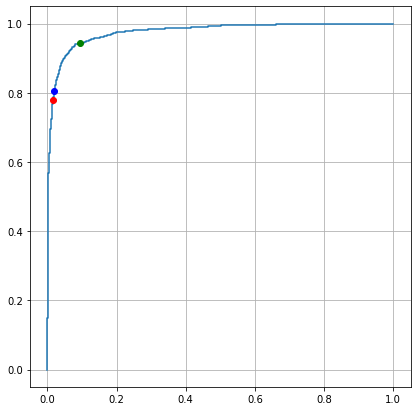

In [27]:
fp, tp, t = skm.roc_curve(y2b, r2e)

plt.figure(figsize=(7, 7))
plt.plot(fp, tp)
plt.plot(f1, r1, "or")
plt.plot(f2, r2, "ob")
plt.plot(f3, r3, "og")

plt.axis("scaled")
plt.grid(True)


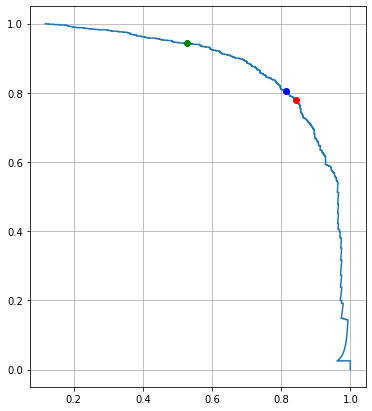

In [28]:
pre, rec, lim = skm.precision_recall_curve(y2b, r2e)
plt.figure(figsize=(7, 7))
plt.plot(pre, rec)
plt.plot(p1, r1, "or")
plt.plot(p2, r2, "ob")
plt.plot(p3, r3, "og")

plt.axis("scaled")
plt.grid(True)


## Precion, Recall and F-score  for the thresholds used

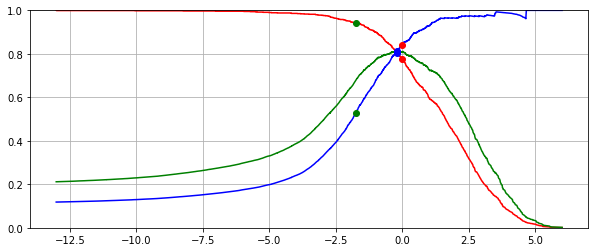

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(lim, pre[:-1], "b")
plt.plot(lim, rec[:-1], "r")
fsc = 2 * pre * rec / (pre + rec)
plt.plot(lim, fsc[:-1], "g")

plt.plot(0, p1, "or")
plt.plot(0, r1, "or")
plt.plot(lim2, p2, "ob")
plt.plot(lim2, r2, "ob")
plt.plot(lim3, p3, "og")
plt.plot(lim3, r3, "og")

plt.axis([np.floor(lim.min()), np.ceil(lim.max()), 0, 1])
plt.grid(True)


In [30]:
np.floor(lim.min())


-14.0

## Model Comparison (try another classifier)

In [31]:
from sklearn.ensemble import RandomForestClassifier

RandF = RandomForestClassifier().fit(X1p, y1b)
y2f = RandF.predict(X2p)
print(confusion_matrix(y2b, y2f))
print("Total number of erros %d (in %d)" % (np.sum(y2b != y2f), y2b.shape[0]))


[[8946   54]
 [ 235  765]]
Total number of erros 289 (in 10000)


In [32]:
r2f = RandF.predict_proba(X2p)[:, 1]
yB = (r2f > 0.5) * 1  # default threshold
print(confusion_matrix(y2b, yB))
print("Total number of erros %d (in %d)" % (np.sum(y2b != yB), y2b.shape[0]))


[[8946   54]
 [ 235  765]]
Total number of erros 289 (in 10000)


Recall: 0.806000 - Precision: 0.814141 - FP-rate: 0.020444


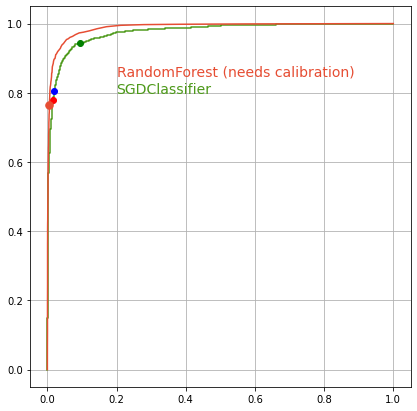

In [33]:
fp, tp, t = skm.roc_curve(y2b, r2e)

plt.figure(figsize=(7, 7))
plt.plot(fp, tp, color=[0.3, 0.6, 0.1])
plt.text(0.2, 0.8, "SGDClassifier", fontsize=14, color=[0.3, 0.6, 0.1])

plt.plot(f1, r1, "or")
plt.plot(f2, r2, "ob")
plt.plot(f3, r3, "og")

fp2, tp2, t2 = skm.roc_curve(y2b, r2f)
r4 = np.sum(yB[y2b == 1] == 1) / (np.sum(yB[y2b == 1] == 1) + np.sum(yB[y2b == 1] == 0))
p4 = np.sum(yB[y2b == 1] == 1) / (np.sum(yB[y2b == 1] == 1) + np.sum(yB[y2b == 0] == 1))
f4 = np.sum(yB[y2b == 0] == 1) / (np.sum(yB[y2b == 0] == 0) + np.sum(yB[y2b == 0] == 1))
print("Recall: %3f - Precision: %3f - FP-rate: %3f" % (r2, p2, f2))
plt.plot(fp2, tp2, color=[0.9, 0.3, 0.2])
plt.text(
    0.2, 0.85, "RandomForest (needs calibration)", fontsize=14, color=[0.9, 0.3, 0.2]
)

plt.plot(f4, r4, ".", ms=15, color=[0.9, 0.3, 0.2])
plt.axis("scaled")
plt.grid(True)
